In [1]:
%%time
import fastai
from fastai.tabular.all import *
from pathlib import Path
import os
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
import IPython
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.tree import export_graphviz
import waterfall_chart
from treeinterpreter import treeinterpreter
from sklearn.inspection import plot_partial_dependence
from scipy.cluster import hierarchy as hc
import xgboost
from xgboost import XGBRegressor

CPU times: user 1.57 s, sys: 1.01 s, total: 2.58 s
Wall time: 1.85 s


In [2]:
df = pd.read_csv("train.csv", low_memory = False)
dep_var = "num_sold"

In [3]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [4]:
%%time
import pickle

country_map = pickle.load(open("embs/country_map.pkl", "rb"))
product_map = pickle.load(open("embs/product_map.pkl", "rb"))
store_map = pickle.load(open("embs/store_map.pkl", "rb"))

CPU times: user 3.48 ms, sys: 0 ns, total: 3.48 ms
Wall time: 2.2 ms


In [5]:
country_map

{'#na#': array([0.01356119, 0.01118535, 0.01405186], dtype=float32),
 'Finland': array([0.49851698, 0.16572799, 0.44117638], dtype=float32),
 'Norway': array([-0.22997577, -0.31350416, -0.36796924], dtype=float32),
 'Sweden': array([-1.012257 , -0.8346111, -0.7070108], dtype=float32)}

In [6]:
product_map

{'#na#': array([ 0.01294461, -0.00381095, -0.01660344], dtype=float32),
 'Kaggle Sticker': array([0.06626856, 0.24443601, 0.01394006], dtype=float32),
 'Kaggle Mug': array([ 0.42592514, -0.52397215,  0.22644173], dtype=float32),
 'Kaggle Hat': array([ 0.12782763, -0.08627668,  0.01692694], dtype=float32)}

In [7]:
store_map

{'#na#': array([-0.00473005, -0.00167127, -0.00394201], dtype=float32),
 'KaggleRama': array([0.6897162 , 1.0390494 , 0.61876696], dtype=float32),
 'KaggleMart': array([0.02370485, 0.11196793, 0.1333581 ], dtype=float32)}

In [8]:
emb_dim = country_map['Finland'].shape[0]
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_country = pd.DataFrame(df['country'].map(country_map).to_list(), columns = col_name)

In [9]:
df_emb_country.head()

,country_emb_1,country_emb_2,country_emb_3
0,0.498517,0.165728,0.441176
1,0.498517,0.165728,0.441176
2,0.498517,0.165728,0.441176
3,0.498517,0.165728,0.441176
4,0.498517,0.165728,0.441176


In [10]:
emb_dim = product_map['Kaggle Mug'].shape[0]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_product = pd.DataFrame(df['product'].map(product_map).to_list(), columns = col_name)

In [11]:
df_emb_product.head()

,product_emb_1,product_emb_2,product_emb_3
0,0.425925,-0.523972,0.226442
1,0.127828,-0.086277,0.016927
2,0.066269,0.244436,0.013940
3,0.425925,-0.523972,0.226442
4,0.127828,-0.086277,0.016927


In [12]:
emb_dim = store_map['KaggleMart'].shape[0]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
df_emb_store = pd.DataFrame(df['store'].map(store_map).to_list(), columns = col_name)

In [13]:
df_emb_store.head()

,store_emb_1,store_emb_2,store_emb_3
0,0.023705,0.111968,0.133358
1,0.023705,0.111968,0.133358
2,0.023705,0.111968,0.133358
3,0.689716,1.039049,0.618767
4,0.689716,1.039049,0.618767


In [14]:
df_tr = pd.concat([df[["date", "num_sold"]], df_emb_store, df_emb_product, df_emb_country], axis = 1)

In [15]:
df_tr.head()

,date,num_sold,store_emb_1,store_emb_2,store_emb_3,product_emb_1,product_emb_2,product_emb_3,country_emb_1,country_emb_2,country_emb_3
0,2015-01-01,329,0.023705,0.111968,0.133358,0.425925,-0.523972,0.226442,0.498517,0.165728,0.441176
1,2015-01-01,520,0.023705,0.111968,0.133358,0.127828,-0.086277,0.016927,0.498517,0.165728,0.441176
2,2015-01-01,146,0.023705,0.111968,0.133358,0.066269,0.244436,0.013940,0.498517,0.165728,0.441176
3,2015-01-01,572,0.689716,1.039049,0.618767,0.425925,-0.523972,0.226442,0.498517,0.165728,0.441176
4,2015-01-01,911,0.689716,1.039049,0.618767,0.127828,-0.086277,0.016927,0.498517,0.165728,0.441176


In [16]:
df_tr = add_datepart(df_tr, 'date')

In [17]:
cond = (df_tr.Year < 2018)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

In [18]:
splits = (list(train_idx), list(valid_idx))
cont, cat = cont_cat_split(df_tr, 1, dep_var)

In [19]:
cont

['store_emb_1',
 'store_emb_2',
 'store_emb_3',
 'product_emb_1',
 'product_emb_2',
 'product_emb_3',
 'country_emb_1',
 'country_emb_2',
 'country_emb_3',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Elapsed']

In [20]:
cat

['Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [21]:
procs = [Categorify, FillMissing]
to = TabularPandas(df_tr, procs, cat, cont, y_names = dep_var, splits = splits)

In [22]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [23]:
def calculate_smape(m, valid_xs, valid_y):
    preds = list(m.predict(valid_xs))
    total = len(preds)
    smape = 0
    for i,j in zip(preds, valid_y) :
        diff = np.abs(i - j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smape += fin
        
    smape = (smape/total) * 100 
    
    return smape

In [24]:
def rf(xs, y, n_estimators = 20, max_samples = 9800, max_features = 0.5, min_samples_leaf = 5, **kwargs):
    return RandomForestRegressor(n_estimators = n_estimators, n_jobs = -1, max_features = max_features, max_samples = max_samples,
                                 min_samples_leaf = min_samples_leaf, oob_score = True).fit(xs, y)

In [25]:
%%time
m1 = rf(xs, y)

CPU times: user 655 ms, sys: 14.3 ms, total: 670 ms
Wall time: 198 ms


In [26]:
calculate_smape(m1, xs, y)

5.048198421832643

In [27]:
calculate_smape(m1, valid_xs, valid_y)

7.937070981675569

In [28]:
m2 = DecisionTreeRegressor(min_samples_leaf = 25)

In [29]:
m2.fit(xs, y)

DecisionTreeRegressor(min_samples_leaf=25)

In [30]:
calculate_smape(m2, xs, y)

6.238943823086538

In [31]:
calculate_smape(m2, valid_xs, valid_y)

9.326763994306027

In [32]:
def cal_smape(preds, targs):
    total = len(targs)
    smp = 0
    for i,j in zip(preds, targs):
        diff = np.abs(i - j)
        avg = ((np.abs(i)) + np.abs(j)) / 2
        fin = diff/avg
        smp += fin
        
    smp = (smp/total) * 100 
    
    return smp

In [33]:
preds1 = m1.predict(valid_xs)
preds2 = m2.predict(valid_xs)

fin_preds = (preds1 + preds2) / 2
cal_smape(fin_preds, valid_y)

8.078332124570418

In [34]:
model = XGBRegressor(learning_rate = 0.025, max_depth = 7, reg_lambda = 0.01, reg_alpha = 0.01,
                     gamma = 0.005, min_child_weight = 5)

In [35]:
model.fit(xs, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.005, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.025, max_delta_step=0,
             max_depth=7, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=7,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
calculate_smape(model, valid_xs, valid_y)

13.255554174821196

In [37]:
calculate_smape(model, xs, y)

8.59232839749304

In [38]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols' : df.columns, 'imp' : m.feature_importances_}).sort_values(by = 'imp', ascending = False)

In [39]:
fi = rf_feat_importance(model, xs)
fi[:10]

,cols,imp
9,product_emb_1,0.743924
6,store_emb_1,0.195694
12,country_emb_1,0.021541
16,Month,0.013450
20,Dayofyear,0.010944
19,Dayofweek,0.004989
17,Week,0.004762
18,Day,0.001539
21,Elapsed,0.001055
15,Year,0.000669


In [40]:
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize = (12, 7), legend = False)

<AxesSubplot:ylabel='cols'>

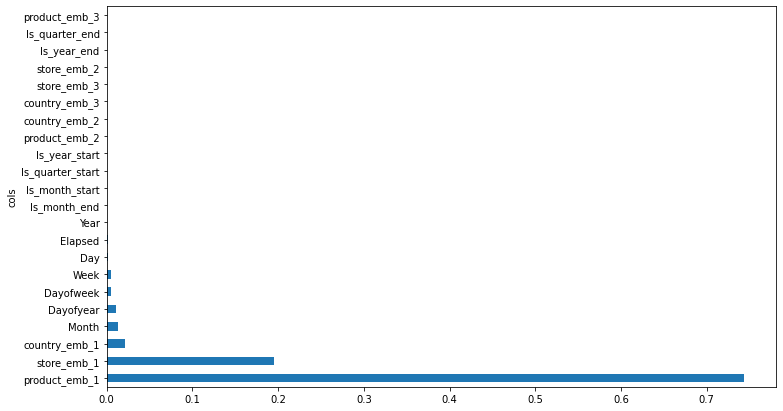

In [41]:
plot_fi(fi[:30])

In [42]:
to_keep = fi[fi.imp>0.005].cols

len(to_keep)

5

In [43]:
to_keep

9     product_emb_1
6       store_emb_1
12    country_emb_1
16            Month
20        Dayofyear
Name: cols, dtype: object

In [44]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
model = XGBRegressor(learning_rate = 0.05, max_depth = 7, reg_lambda = 0.01, reg_alpha = 0.01,
                     gamma = 0.005, min_child_weight = 1)
model.fit(xs_imp, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.005, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=7,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
calculate_smape(model, xs_imp, y)

10.363388465724462

In [46]:
calculate_smape(model, valid_xs_imp, valid_y)

13.521582193338888

In [47]:
m1 = rf(xs_imp, y)

In [48]:
calculate_smape(m1, valid_xs_imp, valid_y)

13.503995871677077

In [49]:
calculate_smape(m1, xs_imp, y)

10.29220218014884

In [50]:
preds1 = m1.predict(valid_xs_imp)
preds2 = model.predict(valid_xs_imp)

fin_preds = (preds1 + preds2) / 2
cal_smape(fin_preds, valid_y)

13.424180350925822

In [51]:
### taking log of dependent variable

In [52]:
df[dep_var] = np.log(df[dep_var])

In [53]:
df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,5.796058
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,6.253829
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,4.983607
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,6.349139
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,6.814543


In [54]:
df_tr = pd.concat([df[["date", "num_sold"]], df_emb_store, df_emb_product, df_emb_country], axis = 1)

In [55]:
df_tr = add_datepart(df_tr, 'date')

In [56]:
splits = (list(train_idx), list(valid_idx))
cont, cat = cont_cat_split(df_tr, 1, dep_var)

procs = [Categorify, FillMissing]
to = TabularPandas(df_tr, procs, cat, cont, y_names = dep_var, splits = splits)

In [57]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [58]:
model = XGBRegressor(learning_rate = 0.05, max_depth = 7, reg_lambda = 0.01, reg_alpha = 0.01,
                     gamma = 0.005, min_child_weight = 1)
model.fit(xs, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.005, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=7,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
calculate_smape(model, xs, y)

0.9262906629481343

In [60]:
calculate_smape(model, valid_xs, valid_y)

1.4790861183283388

In [63]:
cal_smape(np.exp(model.predict(valid_xs)) , np.exp(valid_y))

8.650888639271004

In [64]:
cal_smape(np.exp(model.predict(xs)), np.exp(y))

5.288801362649757

In [65]:
fi = rf_feat_importance(model, xs)
fi[:10]

,cols,imp
9,product_emb_1,0.718670
6,store_emb_1,0.230557
12,country_emb_1,0.030949
19,Dayofweek,0.006491
20,Dayofyear,0.005105
17,Week,0.002700
16,Month,0.001897
21,Elapsed,0.001007
15,Year,0.000831
2,Is_quarter_end,0.000573


In [66]:
to_keep = fi[fi.imp>0.005].cols

len(to_keep)

5

In [67]:
to_keep

9     product_emb_1
6       store_emb_1
12    country_emb_1
19        Dayofweek
20        Dayofyear
Name: cols, dtype: object

In [68]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [69]:
model = XGBRegressor(learning_rate = 0.05, max_depth = 7, reg_lambda = 0.01, reg_alpha = 0.01,
                     gamma = 0.005, min_child_weight = 1)
model.fit(xs_imp, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.005, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=7,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.01, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
cal_smape(model.predict(xs_imp), y)

1.1599923530384042

In [71]:
cal_smape(np.exp(model.predict(xs_imp)), np.exp(y))

6.570981800782165

In [72]:
cal_smape(np.exp(model.predict(valid_xs_imp)), np.exp(valid_y))

15.393173178090933

In [73]:
cal_smape((model.predict(valid_xs_imp)), (valid_y))

2.689912371589152

In [84]:
np.exp(y[0])

329.0

In [100]:
test = pd.read_csv("test.csv")

In [101]:
test["num_sold"] = 0

In [102]:
emb_dim = country_map['Finland'].shape[0]
col_name = [f'country_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_country = pd.DataFrame(test['country'].map(country_map).to_list(), columns = col_name)

In [103]:
emb_dim = product_map['Kaggle Mug'].shape[0]
col_name = [f'product_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_product = pd.DataFrame(test['product'].map(product_map).to_list(), columns = col_name)

In [104]:
emb_dim = store_map['KaggleMart'].shape[0]
col_name = [f'store_emb_{i}' for i in range(1, emb_dim + 1)]
test_emb_store = pd.DataFrame(test['store'].map(store_map).to_list(), columns = col_name)

In [105]:
test_emb_store.head()

,store_emb_1,store_emb_2,store_emb_3
0,0.023705,0.111968,0.133358
1,0.023705,0.111968,0.133358
2,0.023705,0.111968,0.133358
3,0.689716,1.039049,0.618767
4,0.689716,1.039049,0.618767


In [106]:
test.head()

,row_id,date,country,store,product,num_sold
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug,0
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat,0
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker,0
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug,0
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat,0


In [107]:
xs.head()

,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,store_emb_1,store_emb_2,store_emb_3,product_emb_1,...,country_emb_1,country_emb_2,country_emb_3,Year,Month,Week,Day,Dayofweek,Dayofyear,Elapsed
0,1,2,1,2,1,2,0.023705,0.111968,0.133358,0.425925,...,0.498517,0.165728,0.441176,2015,1,1,1,3,1,1.420070e+09
1,1,2,1,2,1,2,0.023705,0.111968,0.133358,0.127828,...,0.498517,0.165728,0.441176,2015,1,1,1,3,1,1.420070e+09
2,1,2,1,2,1,2,0.023705,0.111968,0.133358,0.066269,...,0.498517,0.165728,0.441176,2015,1,1,1,3,1,1.420070e+09
3,1,2,1,2,1,2,0.689716,1.039049,0.618767,0.425925,...,0.498517,0.165728,0.441176,2015,1,1,1,3,1,1.420070e+09
4,1,2,1,2,1,2,0.689716,1.039049,0.618767,0.127828,...,0.498517,0.165728,0.441176,2015,1,1,1,3,1,1.420070e+09


In [108]:
cols = xs.columns

In [109]:
test_fn = pd.concat([test[["date", "num_sold"]],test_emb_country, test_emb_product, test_emb_store ], axis = 1)

In [110]:
test_fn.head()

,date,num_sold,country_emb_1,country_emb_2,country_emb_3,product_emb_1,product_emb_2,product_emb_3,store_emb_1,store_emb_2,store_emb_3
0,2019-01-01,0,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.023705,0.111968,0.133358
1,2019-01-01,0,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.023705,0.111968,0.133358
2,2019-01-01,0,0.498517,0.165728,0.441176,0.066269,0.244436,0.013940,0.023705,0.111968,0.133358
3,2019-01-01,0,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.689716,1.039049,0.618767
4,2019-01-01,0,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.689716,1.039049,0.618767


In [111]:
test_fn = add_datepart(test_fn, 'date')

In [114]:
test_fn.head()

,num_sold,country_emb_1,country_emb_2,country_emb_3,product_emb_1,product_emb_2,product_emb_3,store_emb_1,store_emb_2,store_emb_3,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,0,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.023705,0.111968,0.133358,...,1,1,1,False,True,False,True,False,True,1.546301e+09
1,0,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.023705,0.111968,0.133358,...,1,1,1,False,True,False,True,False,True,1.546301e+09
2,0,0.498517,0.165728,0.441176,0.066269,0.244436,0.013940,0.023705,0.111968,0.133358,...,1,1,1,False,True,False,True,False,True,1.546301e+09
3,0,0.498517,0.165728,0.441176,0.425925,-0.523972,0.226442,0.689716,1.039049,0.618767,...,1,1,1,False,True,False,True,False,True,1.546301e+09
4,0,0.498517,0.165728,0.441176,0.127828,-0.086277,0.016927,0.689716,1.039049,0.618767,...,1,1,1,False,True,False,True,False,True,1.546301e+09


In [113]:
cat

['Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [115]:
to_test = TabularPandas(test_fn, procs, cat, cont, y_names = dep_var, splits = None)

In [116]:
test_xs = to_test.train.xs

In [118]:
preds_test = model.predict(test_xs)

In [119]:
preds_test

array([5.67148  , 6.052163 , 4.8344307, ..., 6.4069295, 7.175567 ,
       6.006358 ], dtype=float32)

In [120]:
preds_test_inv = np.exp(preds_test)

In [121]:
preds_test_inv

array([ 290.46417,  425.0314 ,  125.76696, ...,  606.03   , 1307.1012 ,
        406.00204], dtype=float32)

In [122]:
ids = list(test["row_id"].values)
submission = pd.DataFrame()
submission["row_id"] = ids
submission["num_sold"] = list(preds_test_inv)

In [123]:
submission.head()

,row_id,num_sold
0,26298,290.464172
1,26299,425.031403
2,26300,125.766960
3,26301,454.543945
4,26302,784.032288


In [124]:
submission.to_csv("submission.csv", index = False)